# Add annotations

This notebook takes the dataframe with information about module composition and their labels and adds additional annotations including:

1. Which gene is contained within the modules (both gene id and gene name)
2. Baseline expression and expression in some context of interest
3. How clustered the module is on the genome
4. KEGG pathways that genes are found in
5. GO pathways genes are found in
6. Regulon/operon genes are found in

All this information will help _P. aeruginosa_ experiments filter and determine which module might be interesting to explore.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import scipy.stats
import statsmodels.stats.multitest
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scripts import paths, utils, modules, annotations

random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Clustering method used to obtain gene-module assignments
method = "affinity"
processed = "spell"

In [3]:
# Import gene memberships
pao1_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_modules_{method}_acc_{processed}.tsv"
)
pa14_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pa14_modules_{method}_acc_{processed}.tsv"
)

pao1_membership = pd.read_csv(pao1_membership_filename, sep="\t", index_col=0, header=0)
pa14_membership = pd.read_csv(pa14_membership_filename, sep="\t", index_col=0, header=0)

In [4]:
print(pao1_membership.shape)
print(pa14_membership.shape)

(202, 1)
(530, 1)


In [5]:
pao1_membership.value_counts().median()

5.0

In [6]:
pa14_membership.value_counts().median()

7.0

In [7]:
# Import gene metadata
pao1_gene_annot_filename = paths.GENE_PAO1_ANNOT
pa14_gene_annot_filename = paths.GENE_PA14_ANNOT

pao1_gene_annot = pd.read_csv(pao1_gene_annot_filename, index_col=0, header=0)
pa14_gene_annot = pd.read_csv(pa14_gene_annot_filename, index_col=0, header=0)

In [8]:
# Import metadata of samples
metadata_filename = paths.SAMPLE_METADATA

In [9]:
# Get df with gene ids as indices and gene names as a column
# Having the data in a df instead of a series will just allow me to do my merges that are in the notebook
pao1_gene_annot = pao1_gene_annot["Name"].to_frame("gene name")
pa14_gene_annot = pa14_gene_annot["Name"].to_frame("gene name")

In [10]:
print(pao1_gene_annot.shape)
pao1_gene_annot.tail()

(5677, 1)


,gene name
PAO1_ID,
PA5566,NaN
PA5567,NaN
PA5568,NaN
PA5569,rnpA
PA5570,rpmH


In [11]:
# Use correlation matrix to get length of the genome

## Add gene names

In [12]:
# Add gene names
pao1_gene_module_labels = pao1_membership.merge(
    pao1_gene_annot, left_index=True, right_index=True
)
pa14_gene_module_labels = pa14_membership.merge(
    pa14_gene_annot, left_index=True, right_index=True
)

In [13]:
# Note: Many gene ids don't have an associated gene name and so are NaNs
print(pao1_gene_module_labels.shape)
pao1_gene_module_labels.head()

(202, 2)


,module id,gene name
PA0643,26,NaN
PA3143,0,NaN
PA2853,21,oprI
PA1388,16,NaN
PA3843,21,NaN


In [14]:
# Note: Many gene ids don't have an associated gene name and so are NaNs
print(pa14_gene_module_labels.shape)
pa14_gene_module_labels.head()

(530, 2)


,module id,gene name
PA14_30880,43,NaN
PA14_59190,11,NaN
PA14_55070,30,NaN
PA14_55090,3,NaN
PA14_55000,52,NaN


## Add expression information

1. What is the baseline level of expression for each gene in the module?
2. What is the expression level of genes in a clinical context (i.e. clinical samples)?

In [15]:
# Read in expression data
# Data is of the form SRA sample id x gene id
pao1_compendium = pd.read_csv(paths.PAO1_COMPENDIUM, sep="\t", index_col=0)
pa14_compendium = pd.read_csv(paths.PA14_COMPENDIUM, sep="\t", index_col=0)

In [16]:
print(pao1_compendium.shape)
pao1_compendium.head()

(890, 5563)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541571,5621.037929,902.172829,1380.825635,1811.863764,140.337996,508.725234,483.664878,666.605479,681.641693,77.687105,...,0.0,97.735390,471.134699,12.530178,87.711247,75.181069,77.687105,2288.010535,250.603564,0.000000
ERX541572,6323.898054,835.453446,1754.599065,1814.798699,190.876886,418.460865,321.554138,493.343336,666.600816,45.516796,...,0.0,80.755606,487.470201,10.277986,70.477619,46.985080,60.199633,2218.576726,199.686588,0.000000
ERX541573,4954.119979,893.818410,1984.802645,1752.146970,350.955170,362.785119,373.300630,465.311348,616.471815,42.062043,...,0.0,114.356179,782.091108,19.716583,153.789344,43.376482,106.469546,1474.800376,101.211790,0.000000
ERX541574,4603.356163,773.573295,2227.891090,1911.321096,311.809544,323.710671,435.581271,435.581271,506.988037,78.547442,...,0.0,152.334434,561.733224,21.422030,85.688119,38.083608,64.266089,2116.020491,78.547442,2.380226
ERX541575,4260.451254,875.408119,2140.106080,1788.361959,320.126671,288.509222,276.652679,577.018444,739.057871,57.306626,...,0.0,136.350249,677.799063,15.808725,195.632966,21.736996,118.565434,1650.035620,61.258807,0.000000


In [17]:
print(pa14_compendium.shape)
pa14_compendium.head()

(505, 5891)


,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX1477379,248.707957,13.753435,2.292239,264.753632,68.767177,22.922392,19.484033,55.013742,24.068512,2.292239,...,33.237469,174.210182,1118.612747,264.753632,2.292239,11.461196,449.278890,293.406622,171.917943,181.086900
ERX2174773,56.232678,27.502445,8.594514,7.612284,22.836852,12.032320,5.402266,10.558975,56.723793,6.875611,...,84.226239,46.655934,1115.076822,529.913187,0.000000,43.463686,135.056651,560.853438,73.421707,139.476687
ERX2174774,67.495419,21.860864,9.017607,6.284999,19.401517,12.023475,3.279130,16.395648,60.390638,4.372173,...,89.356283,35.250644,1028.553671,532.038788,0.000000,49.733467,142.915401,738.897218,69.954766,160.404093
ERX2174775,58.088081,24.116927,7.001688,3.889827,18.411847,9.335584,3.889827,16.596595,46.159279,2.852540,...,87.650765,54.716898,1157.612474,485.450392,0.518644,35.267764,168.040520,817.382285,56.532150,67.164344
ERX2174776,50.207404,23.036339,9.746143,4.430065,21.264312,10.632156,4.134727,12.994858,54.342132,2.362701,...,90.964003,49.321391,1087.433313,650.924232,0.295338,50.798080,132.015940,611.348984,64.678950,124.041823


In [18]:
# Calculate median expression across all samples
pao1_median_all = pao1_compendium.median().to_frame("median expression")
pa14_median_all = pa14_compendium.median().to_frame("median expression")

In [19]:
pao1_median_all.head()

,median expression
PA0001,2124.297086
PA0002,1785.667299
PA0003,1237.743632
PA0004,3362.524302
PA0005,300.152951


In [20]:
# TO DO: Have Deb or Georgia select a study
# The following code blocks allow me to Select subset of samples and calculate the median
# expression across that subset of samples.
# An interesting selection would be what the clinical expression is, however
# it looks like we removed many of the clinical isolates from this compendium with our strain binning
# For now I will leave these blocks commented out
# selected_sample_ids = utils.get_sample_ids(
#   metadata_filename, experiment_colname="SRA_study", sample_colname="Experiment", experiment_id="SRP063289")

In [21]:
# Subset compendium
# subset_pao1_compendium = pao1_compendium.loc[selected_sample_ids]
# subset_pa14_compendium = pa14_compendium.loc[selected_sample_ids]

In [22]:
# print(subset_pao1_compendium.shape)
# print(subset_pa14_compendium.shape)

In [23]:
# pao1_median_subset = subset_pao1_compendium.median().to_frame("median subset expression")
# pa14_median_subset = subset_pa14_compendium.median().to_frame("median subset expression")

In [24]:
# Add median expression to gene ids
pao1_gene_annot = pao1_gene_module_labels.merge(
    pao1_median_all, left_index=True, right_index=True, how="left"
)
pa14_gene_annot = pa14_gene_module_labels.merge(
    pa14_median_all, left_index=True, right_index=True, how="left"
)

In [25]:
# Add median subset expression to gene ids
# pao1_gene_annot = pao1_gene_annot.merge(
#    pao1_median_subset, left_index=True, right_index=True, how="left"
# )
# pa14_gene_annot = pa14_gene_annot.merge(
#    pa14_median_subset, left_index=True, right_index=True, how="left"
# )

In [26]:
print(pao1_gene_annot.shape)
pao1_gene_annot.head()

(202, 3)


,module id,gene name,median expression
PA0643,26,NaN,275.986493
PA3143,0,NaN,272.299417
PA2853,21,oprI,25827.931480
PA1388,16,NaN,47.673838
PA3843,21,NaN,40.183509


In [27]:
print(pa14_gene_annot.shape)
pa14_gene_annot.head()

(530, 3)


,module id,gene name,median expression
PA14_30880,43,NaN,12.232781
PA14_59190,11,NaN,266.227121
PA14_55070,30,NaN,79.698939
PA14_55090,3,NaN,176.846261
PA14_55000,52,NaN,28.579641


## Genome location information

How far are genes from other genes in the same module?

In [28]:
# Sort gene ids and get last gene id to use as length of the genome
# This gene id should match the number of gene ids
sorted_pao1_compendium = pao1_compendium.T.sort_index()
pao1_last_gene_id = sorted_pao1_compendium.index[-1]

sorted_pa14_compendium = pa14_compendium.T.sort_index()
pa14_last_gene_id = sorted_pa14_compendium.index[-1]

In [29]:
# Remove "PA" at the beginning of the identifier and convert into a float
pao1_genome_len = float(pao1_last_gene_id.split("PA")[-1])
pa14_genome_len = float(pa14_last_gene_id.split("PA14_")[-1])

In [30]:
print(pao1_genome_len, pa14_genome_len)

5570.0 73420.0


In [31]:
pao1_module_dist = modules.get_intra_module_dist(pao1_gene_annot, "PA", pao1_genome_len)
pa14_module_dist = modules.get_intra_module_dist(
    pa14_gene_annot, "PA14_", pa14_genome_len
)

In [32]:
pao1_module_dist.head(10)

,mean pairwise dist,median pairwise dist,min pairwise dist,max pairwise dist,range pairwise dist
gene id,,,,,
PA3143,1.333333,1.0,1.0,2.0,1.0
PA3144,1.333333,1.0,1.0,2.0,1.0
PA3142,1.333333,1.0,1.0,2.0,1.0
PA3701,1331.142857,1111.0,271.0,2594.0,2323.0
PA3974,1331.142857,1111.0,271.0,2594.0,2323.0
PA5570,1331.142857,1111.0,271.0,2594.0,2323.0
PA4541,1331.142857,1111.0,271.0,2594.0,2323.0
PA2230,1331.142857,1111.0,271.0,2594.0,2323.0
PA4812,1331.142857,1111.0,271.0,2594.0,2323.0


In [33]:
pa14_module_dist.head(10)

,mean pairwise dist,median pairwise dist,min pairwise dist,max pairwise dist,range pairwise dist
gene id,,,,,
PA14_59650,1686.0,260.0,10.0,4860.0,4850.0
PA14_59660,1686.0,260.0,10.0,4860.0,4850.0
PA14_59870,1686.0,260.0,10.0,4860.0,4850.0
PA14_59920,1686.0,260.0,10.0,4860.0,4850.0
PA14_59910,1686.0,260.0,10.0,4860.0,4850.0
PA14_55060,1686.0,260.0,10.0,4860.0,4850.0
PA14_59990,552.0,535.0,100.0,1070.0,970.0
PA14_59270,552.0,535.0,100.0,1070.0,970.0
PA14_58920,552.0,535.0,100.0,1070.0,970.0


In [34]:
# Add module distance to gene names
pao1_gene_annot = pao1_gene_annot.merge(
    pao1_module_dist, left_index=True, right_index=True, how="left"
)
pa14_gene_annot = pa14_gene_annot.merge(
    pa14_module_dist, left_index=True, right_index=True, how="left"
)

In [35]:
pao1_gene_annot.head()

,module id,gene name,median expression,mean pairwise dist,median pairwise dist,min pairwise dist,max pairwise dist,range pairwise dist
PA0643,26,NaN,275.986493,1.666667,1.5,1.0,3.0,2.0
PA3143,0,NaN,272.299417,1.333333,1.0,1.0,2.0,1.0
PA2853,21,oprI,25827.931480,1231.983745,1196.5,1.0,2780.0,2779.0
PA1388,16,NaN,47.673838,2.000000,2.0,1.0,4.0,3.0
PA3843,21,NaN,40.183509,1231.983745,1196.5,1.0,2780.0,2779.0


## Add KEGG pathway enrichment analysis

For each pathway, find significant association of pathways in accessory-accessory modules. This information is only available for PAO1.

The [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test) determines whether there is a significant association between two categorical variables in a contingency table (i.e two classifications of the data). Here we used use the Fisher’s exact test to determine if there is an association between the two classifications: in kegg pathway or not and in accessory-accessory module or not. In other words, we want to determine if there is a statistically significant association between genes found in a given accessory-accessory moudle and the genes involved in a given KEGG pathway. To do this we compare the ratio of genes found in the kegg pathway that are in the accessory-accessory module to the ratio of kegg pathway genes that are not found in the accessory-accessory module.

Since the numbers are large, we also applied the $\chi^2$ test as an alternative to the Fisher's exact test.

In [36]:
pao1_pathway_filename = "https://raw.githubusercontent.com/greenelab/adage/7a4eda39d360b224268921dc1f2c14b32788ab16/Node_interpretation/pseudomonas_KEGG_terms.txt"

In [37]:
pao1_pathways = annotations.load_format_KEGG(pao1_pathway_filename)
pao1_pathways.head()

,1,2
0,,
KEGG-Pathway-pae00072: Synthesis and degradation of ketone bodies,10,"{PA2011, PA3925, PA2003, PA4785, PA2001, PA199..."
KEGG-Pathway-pae00071: Fatty acid degradation,32,"{PA1027, PA0447, PA3299, PA0879, PA3454, PA330..."
KEGG-Pathway-pae00903: Limonene and pinene degradation,9,"{PA1027, PA3426, PA4899, PA3014, PA2475, PA173..."
KEGG-Pathway-pae00380: Tryptophan metabolism,27,"{PA1027, PA0447, PA4613, PA0704, PA3014, PA208..."
KEGG-Pathway-pae00900: Terpenoid backbone biosynthesis,16,"{PA3925, PA3650, PA4785, PA3652, PA2001, PA456..."


In [38]:
pao1_gene_annot.head()

,module id,gene name,median expression,mean pairwise dist,median pairwise dist,min pairwise dist,max pairwise dist,range pairwise dist
PA0643,26,NaN,275.986493,1.666667,1.5,1.0,3.0,2.0
PA3143,0,NaN,272.299417,1.333333,1.0,1.0,2.0,1.0
PA2853,21,oprI,25827.931480,1231.983745,1196.5,1.0,2780.0,2779.0
PA1388,16,NaN,47.673838,2.000000,2.0,1.0,4.0,3.0
PA3843,21,NaN,40.183509,1231.983745,1196.5,1.0,2780.0,2779.0


In [39]:
# Given an accessory-accessory module, look for the array module with the most overlap/significant p-value
def KEGG_enrichment(acc_membership_df, kegg_df):
    all_genes = set(acc_membership_df.index)

    rows = []
    best_rows = []
    # For each accessory-accessory module
    for module_name, module_df_group in acc_membership_df.groupby("module id"):
        num_module_genes = module_df_group.shape[0]
        module_genes = set(module_df_group.index)
        not_module_genes = all_genes.difference(module_genes)

        # Find the KEGG pathway with the best overlap
        for kegg_name in kegg_df.index:
            num_kegg_genes = kegg_df.loc[kegg_name, 1]
            kegg_genes = set(kegg_df.loc[kegg_name, 2])
            not_kegg_genes = all_genes.difference(kegg_genes)

            # Make contingency table
            # -----------------|accessory module |not accessory module
            # kegg pathway     | # genes         | # genes
            # not kegg pathway | # genes         | # genes
            module_kegg_genes = module_genes.intersection(kegg_genes)
            not_module_kegg_genes = not_module_genes.intersection(kegg_genes)
            module_not_kegg_genes = module_genes.intersection(not_kegg_genes)
            not_module_not_kegg_genes = not_module_genes.intersection(not_kegg_genes)

            observed_contingency_table = np.array(
                [
                    [len(module_kegg_genes), len(not_module_kegg_genes)],
                    [len(module_not_kegg_genes), len(not_module_not_kegg_genes)],
                ]
            )

            # Fisher's exact test
            oddsr, pval = scipy.stats.fisher_exact(
                observed_contingency_table, alternative="greater"
            )
            # chi2 test will not accept 0 counts for the contingency table
            # chi2, pval, dof, expected_counts = scipy.stats.chi2_contingency(
            #    observed_contingency_table
            # )
            # print(oddsr, pval)

            rows.append(
                {
                    "module id": module_name,
                    "enriched KEGG pathway": kegg_name,
                    "p-value": pval,
                    "num shared genes": len(module_kegg_genes),
                    "size module": num_module_genes,
                    "size KEGG pathway": num_kegg_genes,
                }
            )

    enrichment_df = pd.DataFrame(rows)

    # Get corrected pvalues
    (
        reject_,
        pvals_corrected_,
        alphacSidak,
        alphacBonf,
    ) = statsmodels.stats.multitest.multipletests(
        enrichment_df["p-value"].values,
        alpha=0.05,
        method="fdr_bh",
        is_sorted=False,
    )

    enrichment_df["corrected p-value"] = pvals_corrected_

    # Select best module mapping
    for grp, grp_df in enrichment_df.groupby("module id"):
        # Find if any pathways is significant
        any_significant = (grp_df["corrected p-value"] < 0.05).any()
        if any_significant:
            best_kegg = grp_df[grp_df["corrected p-value"] < 0.05][
                "enriched KEGG pathway"
            ]
            best_pval = grp_df[grp_df["corrected p-value"] < 0.05]["p-value"].values[0]
            best_shared = grp_df[grp_df["corrected p-value"] < 0.05][
                "num shared genes"
            ].values[0]
            best_module_size = grp_df[grp_df["corrected p-value"] < 0.05][
                "size module"
            ].values[0]
            best_kegg_size = grp_df[grp_df["corrected p-value"] < 0.05][
                "size KEGG pathway"
            ].values[0]
            best_corrected_pval = grp_df[grp_df["corrected p-value"] < 0.05][
                "corrected p-value"
            ].values[0]
            best_rows.append(
                {
                    "module id": grp,
                    "enriched KEGG pathway": best_kegg,
                    "p-value": best_pval,
                    "num shared genes": best_shared,
                    "size module": best_module_size,
                    "size KEGG pathway": best_kegg_size,
                    "corrected p-value": best_corrected_pval,
                }
            )
        else:
            best_rows.append(
                {
                    "module id": grp,
                    "enriched KEGG pathway": "NA",
                    "p-value": "NA",
                    "num shared genes": "NA",
                    "size module": "NA",
                    "size KEGG pathway": "NA",
                    "corrected p-value": "NA",
                }
            )
    best_enrichment_df = pd.DataFrame(best_rows).set_index("module id")

    return best_enrichment_df

In [40]:
pao1_enrichment_df = KEGG_enrichment(pao1_membership, pao1_pathways)

In [41]:
pao1_enrichment_df.head(20)

,enriched KEGG pathway,p-value,num shared genes,size module,size KEGG pathway,corrected p-value
module id,,,,,,
0,NA,NA,NA,NA,NA,NA
1,NA,NA,NA,NA,NA,NA
2,NA,NA,NA,NA,NA,NA
3,NA,NA,NA,NA,NA,NA
4,NA,NA,NA,NA,NA,NA
5,NA,NA,NA,NA,NA,NA
6,NA,NA,NA,NA,NA,NA
7,NA,NA,NA,NA,NA,NA
8,NA,NA,NA,NA,NA,NA


In [42]:
# Add pathway enrichment information
pao1_gene_annot = pao1_gene_annot.merge(
    pao1_enrichment_df, left_on="module id", right_index=True, how="left"
)

In [43]:
pao1_gene_annot.head()

,module id,gene name,median expression,mean pairwise dist,median pairwise dist,min pairwise dist,max pairwise dist,range pairwise dist,enriched KEGG pathway,p-value,num shared genes,size module,size KEGG pathway,corrected p-value
PA0643,26,NaN,275.986493,1.666667,1.5,1.0,3.0,2.0,NA,NA,NA,NA,NA,NA
PA3143,0,NaN,272.299417,1.333333,1.0,1.0,2.0,1.0,NA,NA,NA,NA,NA,NA
PA2853,21,oprI,25827.931480,1231.983745,1196.5,1.0,2780.0,2779.0,NA,NA,NA,NA,NA,NA
PA1388,16,NaN,47.673838,2.000000,2.0,1.0,4.0,3.0,NA,NA,NA,NA,NA,NA
PA3843,21,NaN,40.183509,1231.983745,1196.5,1.0,2780.0,2779.0,NA,NA,NA,NA,NA,NA


## Import and format operon

In [44]:
pao1_operon_filename = paths.PAO1_OPERON
pa14_operon_filename = paths.PA14_OPERON

In [45]:
pao1_operon = annotations.load_format_operons(pao1_operon_filename)
pa14_operon = annotations.load_format_operons(pa14_operon_filename)

In [46]:
pao1_operon.head()

,operon_name
locus_tag,
PA0001,dnaA-dnaN-recF-gyrB
PA0002,dnaA-dnaN-recF-gyrB
PA0003,dnaA-dnaN-recF-gyrB
PA0004,dnaA-dnaN-recF-gyrB
PA0005,PA0006-lptA


In [47]:
# Add operons to pathway annotations for PAO1
pao1_gene_annot = pao1_gene_annot.merge(
    pao1_operon, left_index=True, right_index=True, how="left"
)

In [48]:
print(pao1_gene_annot.shape)
pao1_gene_annot.head()

(202, 15)


,module id,gene name,median expression,mean pairwise dist,median pairwise dist,min pairwise dist,max pairwise dist,range pairwise dist,enriched KEGG pathway,p-value,num shared genes,size module,size KEGG pathway,corrected p-value,operon_name
PA0643,26,NaN,275.986493,1.666667,1.5,1.0,3.0,2.0,NA,NA,NA,NA,NA,NA,PA0643-PA0644-PA0645
PA3143,0,NaN,272.299417,1.333333,1.0,1.0,2.0,1.0,NA,NA,NA,NA,NA,NA,wbpL-PA3144-PA3143-PA3142
PA2853,21,oprI,25827.931480,1231.983745,1196.5,1.0,2780.0,2779.0,NA,NA,NA,NA,NA,NA,NaN
PA1388,16,NaN,47.673838,2.000000,2.0,1.0,4.0,3.0,NA,NA,NA,NA,NA,NA,PA1387-PA1388
PA3843,21,NaN,40.183509,1231.983745,1196.5,1.0,2780.0,2779.0,NA,NA,NA,NA,NA,NA,spcS-PA3843


In [49]:
# For PA14 we only have operon annotations
pa14_gene_annot = pa14_gene_annot.merge(
    pa14_operon, left_index=True, right_index=True, how="left"
)

## Add regulon

For each regulon, what genes are contained in it. This information is only available for PAO1

In [50]:
pao1_regulon_filename = "https://raw.githubusercontent.com/greenelab/core-accessory-interactome/6635c0e357c0172c2cebd0368648030e0ee4beaf/data/metadata/regulons_format.csv"

pao1_regulons = pd.read_csv(pao1_regulon_filename, index_col=0, header=0)

In [51]:
pao1_regulons["Genes"] = pao1_regulons["Genes"].str.split(";").apply(set)

In [52]:
gene_to_regulons_df = pd.DataFrame(
    index=pao1_gene_module_labels.index, columns=list(pao1_regulons.index)
)

In [53]:
%%time
for gene in gene_to_regulons_df.index:
    gene_to_regulons_df.loc[gene] = [
        gene in pao1_regulons.loc[regulon, "Genes"] for regulon in pao1_regulons.index
    ]

CPU times: user 42.6 ms, sys: 0 ns, total: 42.6 ms
Wall time: 42.3 ms


In [54]:
# Add regulons to other annotations
pao1_gene_annot = pao1_gene_annot.merge(
    gene_to_regulons_df, left_index=True, right_index=True, how="left"
)

In [55]:
print(pao1_gene_annot.shape)
pao1_gene_annot.head()

(202, 32)


,module id,gene name,median expression,mean pairwise dist,median pairwise dist,min pairwise dist,max pairwise dist,range pairwise dist,enriched KEGG pathway,p-value,...,PqsR_regulon,QscR_regulon,VreI_regulon,Zur_regulon,Anr_short_list,PhoB_short_list,AlgU_short_list,LasR_short_list,RhlR_short_list,PqsR_short_list
PA0643,26,NaN,275.986493,1.666667,1.5,1.0,3.0,2.0,NA,NA,...,False,False,False,False,False,False,False,False,False,False
PA3143,0,NaN,272.299417,1.333333,1.0,1.0,2.0,1.0,NA,NA,...,False,False,False,False,False,False,False,False,False,False
PA2853,21,oprI,25827.931480,1231.983745,1196.5,1.0,2780.0,2779.0,NA,NA,...,False,False,False,False,False,False,False,False,False,False
PA1388,16,NaN,47.673838,2.000000,2.0,1.0,4.0,3.0,NA,NA,...,False,False,False,False,False,False,False,False,False,False
PA3843,21,NaN,40.183509,1231.983745,1196.5,1.0,2780.0,2779.0,NA,NA,...,False,False,False,False,False,False,False,False,False,False


In [56]:
print(pa14_gene_annot.shape)
pa14_gene_annot.head()

(530, 9)


,module id,gene name,median expression,mean pairwise dist,median pairwise dist,min pairwise dist,max pairwise dist,range pairwise dist,operon_name
PA14_30880,43,NaN,12.232781,165.128205,165.0,10.0,400.0,390.0,PA14_30880-PA14_30870-PA14_30860-PA14_30850
PA14_59190,11,NaN,266.227121,170.357143,40.0,10.0,610.0,600.0,NaN
PA14_55070,30,NaN,79.698939,18755.000000,20210.0,170.0,33690.0,33520.0,PA14_55070-PA14_55060
PA14_55090,3,NaN,176.846261,14450.166667,21494.5,3.0,21736.0,21733.0,PA14_55080-PA14_55090
PA14_55000,52,NaN,28.579641,2248.954248,70.0,10.0,19780.0,19770.0,PA14_55000-PA14_55020-PA14_55030-PA14_55040


## Plot trends

In general, accessory genes thought to be acquired from other bacterial strains (https://academic.oup.com/femsle/article/356/2/235/542446) and clustered in islands along the genome ([Kung et al](https://pubmed.ncbi.nlm.nih.gov/21119020/)). So we would expect most accessory gene modules to have a small range.

However, maybe there are some accessory modules that have a large intra-gene distance where genes form relationships that are long range. This might indicate accessory genes coming to be regulated after integration.

Evidence of regulation changing after integration: integration of ICE clc resulted in uncoupling of the clc integrase gene from its constitutive promoter: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC107606/

Note: We will likely not focus on these accessory genes with a high range because we will be getting into Pa evolution, which will require a different type of analysis.

In [57]:
# Get pairwise distance per module
# Otherwise plotting will be scaled by the number of genes in a module
pao1_mean_dist = []
for grp_name, grp_df in pao1_gene_annot.groupby("module id"):
    pao1_mean_dist.append(grp_df["mean pairwise dist"][0])

pa14_mean_dist = []
for grp_name, grp_df in pa14_gene_annot.groupby("module id"):
    pa14_mean_dist.append(grp_df["mean pairwise dist"][0])

Text(0.5, 1.0, 'Mean pairwise distance of PAO1 accessory modules')

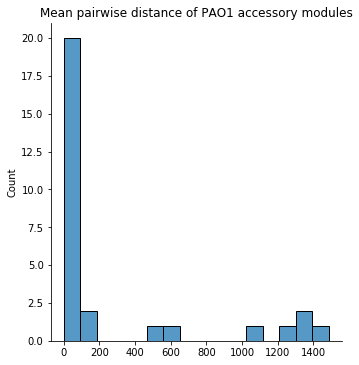

In [58]:
sns.displot(pao1_mean_dist)
plt.title("Mean pairwise distance of PAO1 accessory modules")

Text(0.5, 1.0, 'Mean pairwise distance of PA14 accessory modules')

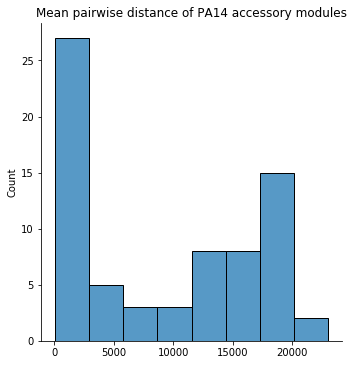

In [59]:
sns.displot(pa14_mean_dist)
plt.title("Mean pairwise distance of PA14 accessory modules")

In [60]:
# Find which modules/genes have a large range
pao1_farapart_genes = pao1_gene_annot[pao1_gene_annot["mean pairwise dist"] >= 2000]

In [61]:
pa14_farapart_genes = pa14_gene_annot[pa14_gene_annot["mean pairwise dist"] >= 20000]

In [62]:
# Save
pao1_gene_annot.to_csv(
    f"pao1_acc_gene_module_annotated_{method}_{processed}.tsv", sep="\t"
)
pa14_gene_annot.to_csv(
    f"pa14_acc_gene_module_annotated_{method}_{processed}.tsv", sep="\t"
)
pao1_farapart_genes.to_csv(
    f"pao1_farapart_acc_modules_{method}_{processed}.tsv", sep="\t"
)
pa14_farapart_genes.to_csv(
    f"pa14_farapart_acc_modules_{method}_{processed}.tsv", sep="\t"
)

These annotations will be used to help _P. aeruginosa_ experts, like our collaborators, to determine what accessory-accessory modules to focus on.


Note: Since genes can be in multiple KEGG pathways and regulons, each pathway and regulon are separate columns. Whereas operons are a single column since genes can belong to only a single operon.